In [1]:
import fiona, utm, os, re
import datetime
import rasterio
import pandas as pd
from rasterio.mask import mask
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
fields = {}
field_names = ['20', '21', '22', '23', '17', '18']
for field_name in field_names:
    with fiona.open('/Users/vasilii/Desktop/research/rostov/rassvetQGIS.GEOJSON', 'r') as shapefile:
        fields[field_name] = [feature['geometry'] for feature in shapefile
                              if feature['properties']['name'] == field_name]
        
for field_name in field_names:
    for field in fields[field_name]:
        if field['type']=='Polygon':
            field['coordinates'] = [[utm.from_latlon(i[1], i[0])[:2] for i in field['coordinates'][0]]]
        else:
            geoms = []
            for geom in field['coordinates']:
                geoms.append([[utm.from_latlon(i[1], i[0])[:2] for i in geom[0]]])
            field['coordinates'] = geoms

In [3]:
ndvis = {}
for field_name in field_names:
    ndvis[field_name] = {}

# Sentinel 2

In [3]:
dates = []
for filename in os.listdir('/Users/vasilii/Desktop/sentinel_tif/'):
    if filename.endswith('04.tif'):
        dates.append(filename.split('.')[0][:8])

In [20]:
band_04 = rasterio.open('/Users/vasilii/Desktop/sentinel_tif/30_06_17_04.tif')
band_08 = rasterio.open('/Users/vasilii/Desktop/sentinel_tif/30_06_17_08.tif')

masked_04_20 = mask(band_04, fields['20'], nodata=0, crop=True)
masked_08_20 = mask(band_08, fields['20'], nodata=0, crop=True)

masked_04_17 = mask(band_04, fields['17'], nodata=0, crop=True)
masked_08_17 = mask(band_08, fields['17'], nodata=0, crop=True)

masked_04_23 = mask(band_04, fields['23'], nodata=0, crop=True)
masked_08_23 = mask(band_08, fields['23'], nodata=0, crop=True)

band_04.close()
band_08.close()

examples of fields

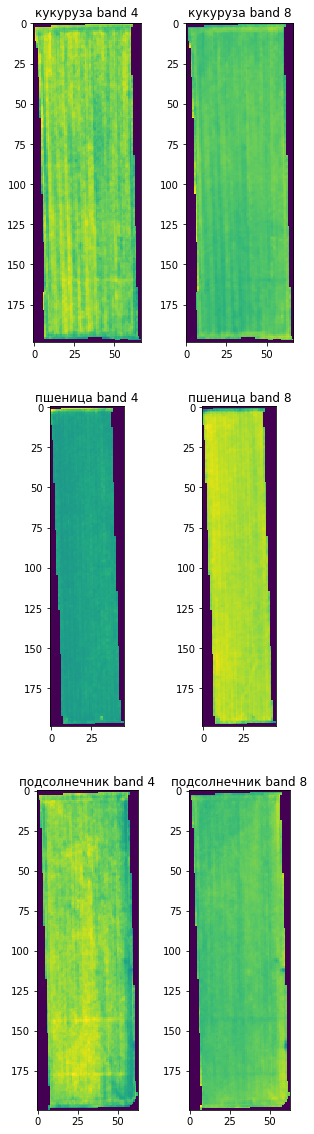

In [47]:
plt.figure(figsize=(5,20))
plt.subplot(321)
plt.imshow(masked_04_20[0].data[0])
plt.title('кукуруза band 4')
plt.subplot(322)
plt.imshow(masked_08_20[0].data[0])
plt.title('кукуруза band 8')
plt.subplot(323)
plt.imshow(masked_04_17[0].data[0])
plt.title('пшеница band 4')
plt.subplot(324)
plt.imshow(masked_08_17[0].data[0])
plt.title('пшеница band 8')
plt.subplot(325)
plt.imshow(masked_04_23[0].data[0])
plt.title('подсолнечник band 4')
plt.subplot(326)
plt.imshow(masked_08_23[0].data[0])
plt.title('подсолнечник band 8')
plt.show()

In [106]:
for date in dates:
    band_04 = rasterio.open('/Users/vasilii/Desktop/sentinel_tif/'+date+'_04.tif')
    band_08 = rasterio.open('/Users/vasilii/Desktop/sentinel_tif/'+date+'_08.tif')
    
    for field_name in field_names:
        masked_04 = mask(band_04, fields[field_name], nodata=0, crop=True)
        masked_08 = mask(band_08, fields[field_name], nodata=0, crop=True)
        
        field_04 = masked_04[0].data[0].astype('int16')
        field_08 = masked_08[0].data[0].astype('int16')
        
        field_04 = field_04[np.nonzero(field_04)]
        field_08 = field_08[np.nonzero(field_08)]

        ndvis[field_name][datetime.datetime.strptime(date, '%d_%m_%y').date()] = np.mean((field_08-field_04)/
                                                                                         (field_08+field_04))
    
    band_04.close()
    band_08.close()

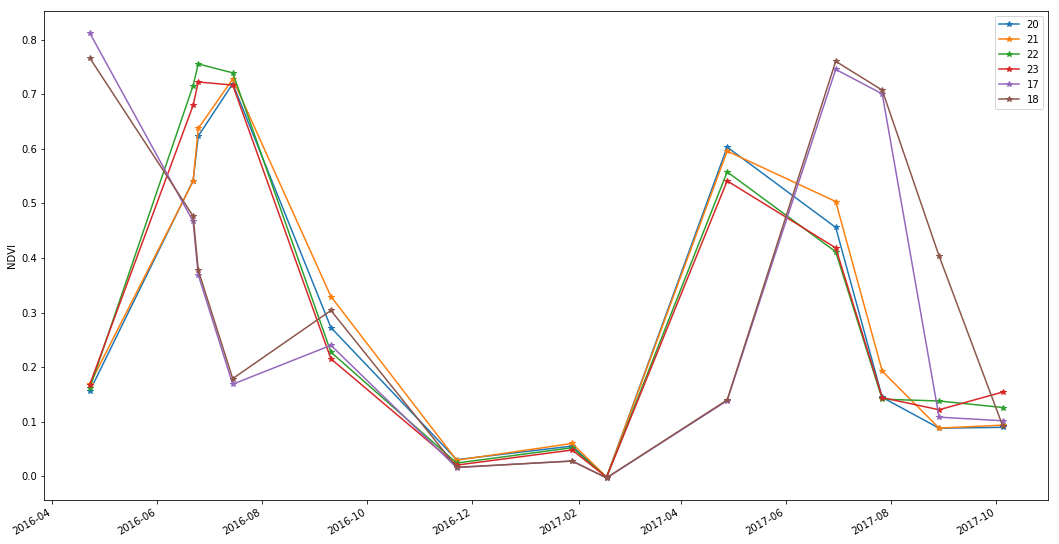

In [107]:
plt.figure(figsize=(18,10))
for field_name in field_names:
    plt.plot(sorted(ndvis[field_name]), [ndvis[field_name][date] for date in sorted(ndvis[field_name])],
             '*-', label=field_name)
plt.gcf().autofmt_xdate()
plt.legend()
plt.ylabel('NDVI')
plt.show()

20, 21 - corn

22, 23 - sunflower

17, 18 - wheat

In [108]:
print('date', end='\t\t')
for field_name in field_names:
    print('F.', field_name, end='\t')
print()
for date in sorted(ndvis[field_name]):
    print(date, end='\t')
    for field_name in field_names:
        print('%.3f' % round(ndvis[field_name][date], 3), end='\t')
    print()

date		F. 20	F. 21	F. 22	F. 23	F. 17	F. 18	
2016-04-23	0.156	0.168	0.161	0.168	0.812	0.767	
2016-06-22	0.542	0.540	0.716	0.679	0.467	0.477	
2016-06-25	0.623	0.637	0.755	0.722	0.369	0.377	
2016-07-15	0.719	0.728	0.739	0.717	0.169	0.179	
2016-09-10	0.272	0.329	0.227	0.215	0.240	0.304	
2016-11-22	0.030	0.029	0.024	0.020	0.016	0.016	
2017-01-28	0.055	0.060	0.052	0.048	0.028	0.028	
2017-02-17	-0.002	-0.001	-0.002	-0.002	-0.003	-0.003	
2017-04-28	0.603	0.596	0.558	0.541	0.139	0.140	
2017-06-30	0.456	0.503	0.411	0.418	0.746	0.760	
2017-07-27	0.144	0.193	0.141	0.144	0.701	0.708	
2017-08-29	0.088	0.088	0.138	0.122	0.108	0.404	
2017-10-05	0.090	0.094	0.126	0.154	0.102	0.092	


# Sentinel 2 (more data)

In [35]:
root = '/Users/vasilii/Desktop/sentinel/'
for folder in next(os.walk(root))[1]:
    date = re.findall('(\d+)T', folder)[-1]
    for granule in next(os.walk(root+folder+'/GRANULE'))[1]:
        if 'T37TFM' in granule:
            for image in next(os.walk(root+folder+'/GRANULE/'+granule+'/IMG_DATA'))[2]:
                if '_B04.jp2' in image:
                    band_04 = rasterio.open(root+folder+'/GRANULE/'+granule+'/IMG_DATA/'+image)
                elif '_B08.jp2' in image:
                    band_08 = rasterio.open(root+folder+'/GRANULE/'+granule+'/IMG_DATA/'+image)
    
    for field_name in field_names:
        masked_04 = mask(band_04, fields[field_name], nodata=0, crop=True)
        masked_08 = mask(band_08, fields[field_name], nodata=0, crop=True)

        field_04 = masked_04[0].data[0].astype('int16')
        field_08 = masked_08[0].data[0].astype('int16')

        field_04 = field_04[np.nonzero(field_04)]
        field_08 = field_08[np.nonzero(field_08)]
        
        ndvis[field_name][datetime.datetime.strptime(date, '%Y%m%d').date()] = np.mean((field_08-field_04)/
                                                                                         (field_08+field_04))
    
    band_04.close()
    band_08.close()

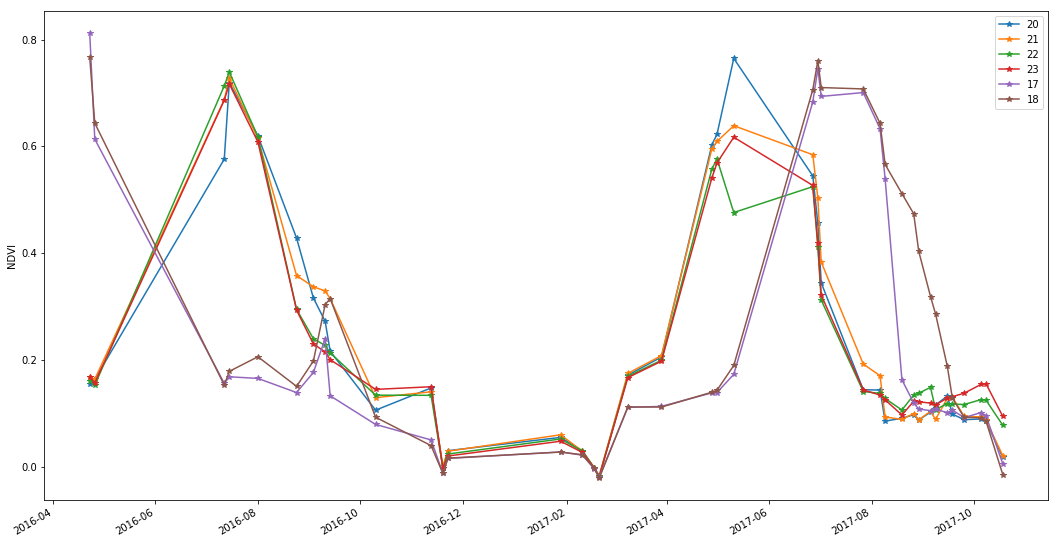

In [36]:
plt.figure(figsize=(18,10))
for field_name in field_names:
    plt.plot(sorted(ndvis[field_name]), [ndvis[field_name][date] for date in sorted(ndvis[field_name])],
             '*-', label=field_name)
plt.gcf().autofmt_xdate()
plt.legend()
plt.ylabel('NDVI')
plt.show()

In [37]:
print('date', end='\t\t')
for field_name in field_names:
    print('F.', field_name, end='\t')
print()
for date in sorted(ndvis[field_name]):
    print(date, end='\t')
    for field_name in field_names:
        print('%.3f' % round(ndvis[field_name][date], 3), end='\t')
    print()

date		F. 20	F. 21	F. 22	F. 23	F. 17	F. 18	
2016-04-23	0.156	0.168	0.161	0.168	0.812	0.767	
2016-04-26	0.164	0.164	0.153	0.157	0.613	0.644	
2016-07-12	0.576	0.687	0.713	0.686	0.156	0.153	
2016-07-15	0.719	0.728	0.739	0.717	0.169	0.179	
2016-08-01	0.620	0.615	0.618	0.608	0.166	0.206	
2016-08-24	0.428	0.358	0.295	0.294	0.139	0.151	
2016-09-03	0.316	0.337	0.240	0.230	0.177	0.198	
2016-09-10	0.272	0.329	0.227	0.215	0.240	0.304	
2016-09-13	0.216	0.315	0.213	0.201	0.133	0.315	
2016-10-10	0.106	0.130	0.134	0.145	0.079	0.093	
2016-11-12	0.148	0.141	0.134	0.150	0.050	0.040	
2016-11-19	-0.001	0.002	-0.002	-0.002	-0.012	-0.012	
2016-11-22	0.030	0.029	0.024	0.020	0.016	0.016	
2017-01-28	0.055	0.060	0.052	0.048	0.028	0.028	
2017-02-10	0.030	0.029	0.030	0.027	0.022	0.023	
2017-02-17	-0.002	-0.001	-0.002	-0.002	-0.003	-0.003	
2017-02-20	-0.018	-0.016	-0.018	-0.018	-0.019	-0.021	
2017-03-09	0.172	0.175	0.169	0.167	0.111	0.112	
2017-03-29	0.206	0.208	0.200	0.198	0.113	0.112	
2017-04-28	0.603	0.596	0.558

# Landsat 8

In [7]:
band_04 = rasterio.open('/Users/vasilii/Desktop/landsat/LC08_L1TP_173028_20170606_20170616_01_T1/LC08_L1TP_173028_20170606_20170616_01_T1_B4.TIF')
band_05 = rasterio.open('/Users/vasilii/Desktop/landsat/LC08_L1TP_173028_20170606_20170616_01_T1/LC08_L1TP_173028_20170606_20170616_01_T1_B5.TIF')

masked_04_20 = mask(band_04, fields['20'], nodata=0, crop=True)
masked_05_20 = mask(band_05, fields['20'], nodata=0, crop=True)

masked_04_17 = mask(band_04, fields['17'], nodata=0, crop=True)
masked_05_17 = mask(band_05, fields['17'], nodata=0, crop=True)

masked_04_23 = mask(band_04, fields['23'], nodata=0, crop=True)
masked_05_23 = mask(band_05, fields['23'], nodata=0, crop=True)

band_04.close()
band_05.close()

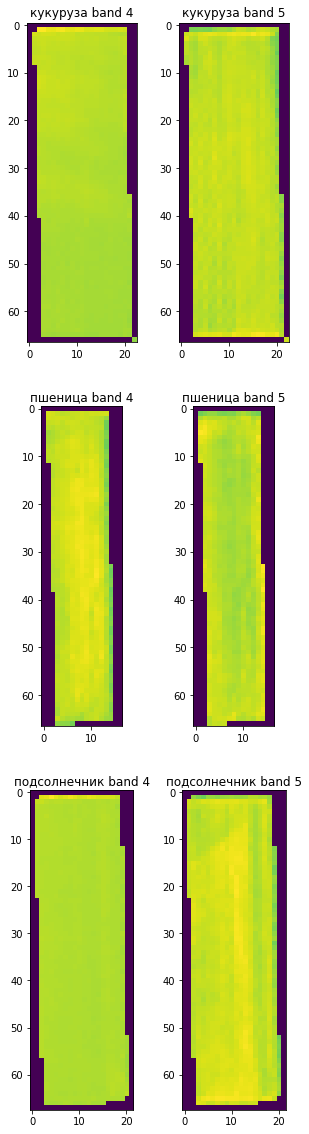

In [28]:
plt.figure(figsize=(5,20))
plt.subplot(321)
plt.imshow(masked_04_20[0].data[0])
plt.title('кукуруза band 4')
plt.subplot(322)
plt.imshow(masked_05_20[0].data[0])
plt.title('кукуруза band 5')
plt.subplot(323)
plt.imshow(masked_04_17[0].data[0])
plt.title('пшеница band 4')
plt.subplot(324)
plt.imshow(masked_05_17[0].data[0])
plt.title('пшеница band 5')
plt.subplot(325)
plt.imshow(masked_04_23[0].data[0])
plt.title('подсолнечник band 4')
plt.subplot(326)
plt.imshow(masked_05_23[0].data[0])
plt.title('подсолнечник band 5')
plt.show()

In [20]:
root = '/Users/vasilii/Desktop/landsat/'
for folder in next(os.walk(root))[1]:
    date = folder.split('_')[3]

    band_04 = rasterio.open(root+folder+'/'+folder+'_B4.TIF')
    band_05 = rasterio.open(root+folder+'/'+folder+'_B5.TIF')
    
    for field_name in field_names:
        masked_04 = mask(band_04, fields[field_name], nodata=0, crop=True)
        masked_05 = mask(band_05, fields[field_name], nodata=0, crop=True)

        field_04 = masked_04[0].data[0].astype('int16')
        field_05 = masked_05[0].data[0].astype('int16')

        field_04 = field_04[np.nonzero(field_04)]
        field_05 = field_05[np.nonzero(field_05)]
        
        ndvis[field_name][datetime.datetime.strptime(date, '%Y%m%d').date()] = np.mean((field_05-field_04)/
                                                                                         (field_05+field_04))
    
    band_04.close()
    band_05.close()

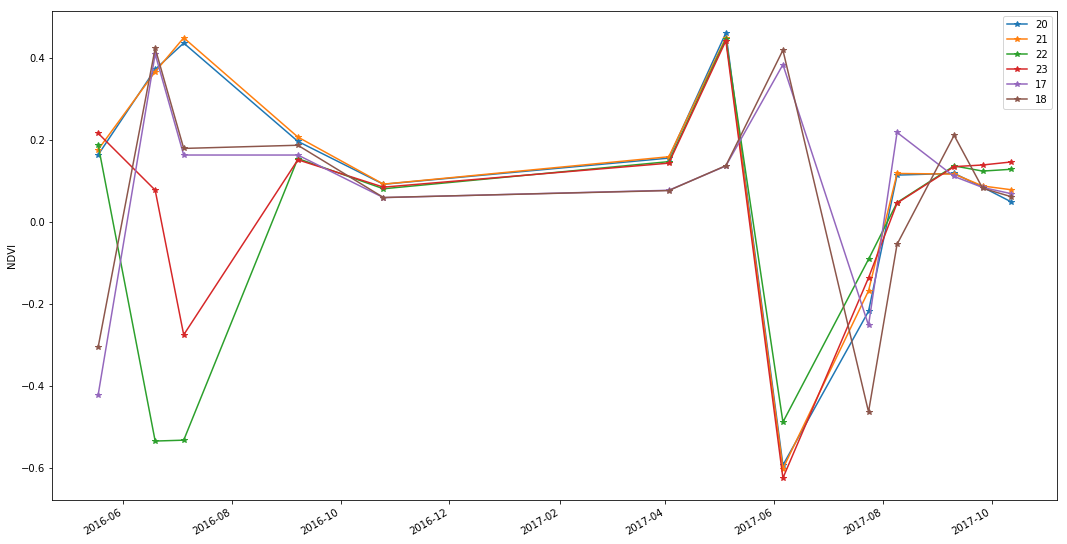

In [22]:
plt.figure(figsize=(18,10))
for field_name in field_names:
    plt.plot(sorted(ndvis[field_name]), [ndvis[field_name][date] for date in sorted(ndvis[field_name])],
             '*-', label=field_name)
plt.gcf().autofmt_xdate()
plt.legend()
plt.ylabel('NDVI')
plt.show()

In [23]:
print('date', end='\t\t')
for field_name in field_names:
    print('F.', field_name, end='\t')
print()
for date in sorted(ndvis[field_name]):
    print(date, end='\t')
    for field_name in field_names:
        print('%.3f' % round(ndvis[field_name][date], 3), end='\t')
    print()

date		F. 20	F. 21	F. 22	F. 23	F. 17	F. 18	
2016-05-18	0.164	0.176	0.188	0.216	-0.422	-0.305	
2016-06-19	0.372	0.366	-0.534	0.078	0.409	0.423	
2016-07-05	0.436	0.449	-0.532	-0.275	0.163	0.179	
2016-09-07	0.196	0.207	0.155	0.152	0.163	0.187	
2016-10-25	0.092	0.092	0.081	0.085	0.059	0.060	
2017-04-03	0.156	0.159	0.147	0.143	0.077	0.077	
2017-05-05	0.461	0.449	0.446	0.441	0.137	0.137	
2017-06-06	-0.592	-0.601	-0.488	-0.624	0.383	0.419	
2017-07-24	-0.218	-0.168	-0.091	-0.136	-0.252	-0.463	
2017-08-09	0.114	0.118	0.047	0.046	0.218	-0.054	
2017-09-10	0.118	0.117	0.137	0.135	0.111	0.211	
2017-09-26	0.085	0.088	0.124	0.139	0.084	0.082	
2017-10-12	0.049	0.079	0.128	0.146	0.069	0.062	
